# Import data

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization

In [0]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
%%time
X_df = pd.read_csv("drive/My Drive/HH_paramter_space_40s.csv",index_col=0)
y_df = pd.read_csv("drive/My Drive/HH_voltage_40s.csv",index_col=0)


CPU times: user 1.35 s, sys: 108 ms, total: 1.46 s
Wall time: 3.22 s


In [0]:
ag_df = pd.read_csv("drive/My Drive/HH_ag.csv",index_col=0)

In [0]:
foo_df = ag_df['first_ap_time']

In [0]:
sum(~pd.isna(foo_df))

2187

In [0]:
names = ['gbar_Na','gbar_L','E_L','Cm','gbar_K','E_Na','E_K']
X_df.columns=names
X = X_df.values
y = y_df.values
y = y[:,:1201]

In [0]:
X_df.describe()

,gbar_Na,gbar_L,E_L,Cm,gbar_K,E_Na,E_K
count,2187.000000,2187.000000,2187.000000,2187.000000,2187.000000,2187.000000,2187.000000
mean,119.999812,0.300000,-54.399868,1.000001,36.000011,50.000058,-77.000241
std,13.859568,0.034648,6.283135,0.115497,4.157874,5.774797,8.893226
min,96.008101,0.240041,-65.277294,0.800180,28.801198,40.006009,-92.392450
25%,108.009501,0.270010,-59.840620,0.900065,32.401137,45.002375,-84.697100
50%,119.999996,0.300013,-54.400964,1.000036,36.000697,49.996375,-76.997887
75%,131.997179,0.329996,-48.959416,1.099977,39.597244,54.997873,-69.304729
max,143.985585,0.359957,-43.529069,1.199897,43.198358,59.991873,-61.603495


Next cell creates second order and interaction names

In [0]:
from copy import copy
def sonames(names):
  all_names = copy(names)
  for i,name in enumerate(names):
    all_names.extend([name0+'^2' if name0==name else name+'*'+name0 for name0 in names[i:]])
  return all_names

snames = sonames(names)


# Import matlab structures

The structures are created using HPLSR.m and HPLSRpred.m in matlab. 

In [0]:
dir_path = "drive/My Drive/MatlabResults/HHag/"

In [0]:
!ls drive/My\ Drive/MatlabResults/HHag

global_PLSR_training.mat  local_PLSR_training.mat  PLSR_scores.mat


In [0]:
from scipy import io
global_training = io.loadmat(dir_path+'global_PLSR_training.mat')
local_training =  io.loadmat(dir_path+'local_PLSR_training.mat')
PLSR_scores =  io.loadmat(dir_path+'PLSR_scores.mat')

In [0]:
gt_struct = global_training['global_train_model']
lt_struct = local_training['local_train_model']
sc_struct = PLSR_scores['train_model_ls']



In [0]:
gt_val = gt_struct[0,0]
lt_val = lt_struct[0,0]
sc_val = sc_struct[0,0]

In [0]:
LX = sc_val['LX']
SX = sc_val['SX']
LY = sc_val['LY']
SY = sc_val['SY']
W = sc_val['W']
LXgr = sc_val['LXgr']
SXgr = sc_val['SXgr']
LYgr = sc_val['LYgr']
SYgr = sc_val['SYgr']
Wgr = sc_val['Wgr']

R2 = gt_val['R2']
B = gt_val['B']
options = gt_val['options']
tf = gt_val['tf']
MSE = gt_val['MSE']
RMSEP = gt_val['RMSEP']
pctvar = gt_val['pctvar']
Ypred = gt_val['Ypred']
optPCs = gt_val['optPCs']

cluster_centers = lt_val['cluster_centers']
Bgr = lt_val['Bgr']
options = lt_val['options']
tf = lt_val['tf']
clusters = lt_val['clusters']
optPCsgr = lt_val['optPCsgr']
pctvargr = lt_val['pctvargr']
Ypredgr = lt_val['Ypredgr']
MSEgr = lt_val['MSEgr']
RMSEPgr = lt_val['RMSEPgr']

In [0]:
tf = tf.squeeze()
indexes = tf == 1

In [0]:
X_train = X[indexes,:]
X_test = X[~indexes,:]
y_train = y[indexes,:]
y_test = y[~indexes,:]

In [0]:
clusters = clusters.squeeze()

In [0]:
ag_names = list(ag_df.columns[1:])

In [0]:
ag_names = ['Time to AP','Amplitude of AP','Width of AP']

In [0]:
headers = ['B0'] +  snames

# Plots

## Main regression coefficients

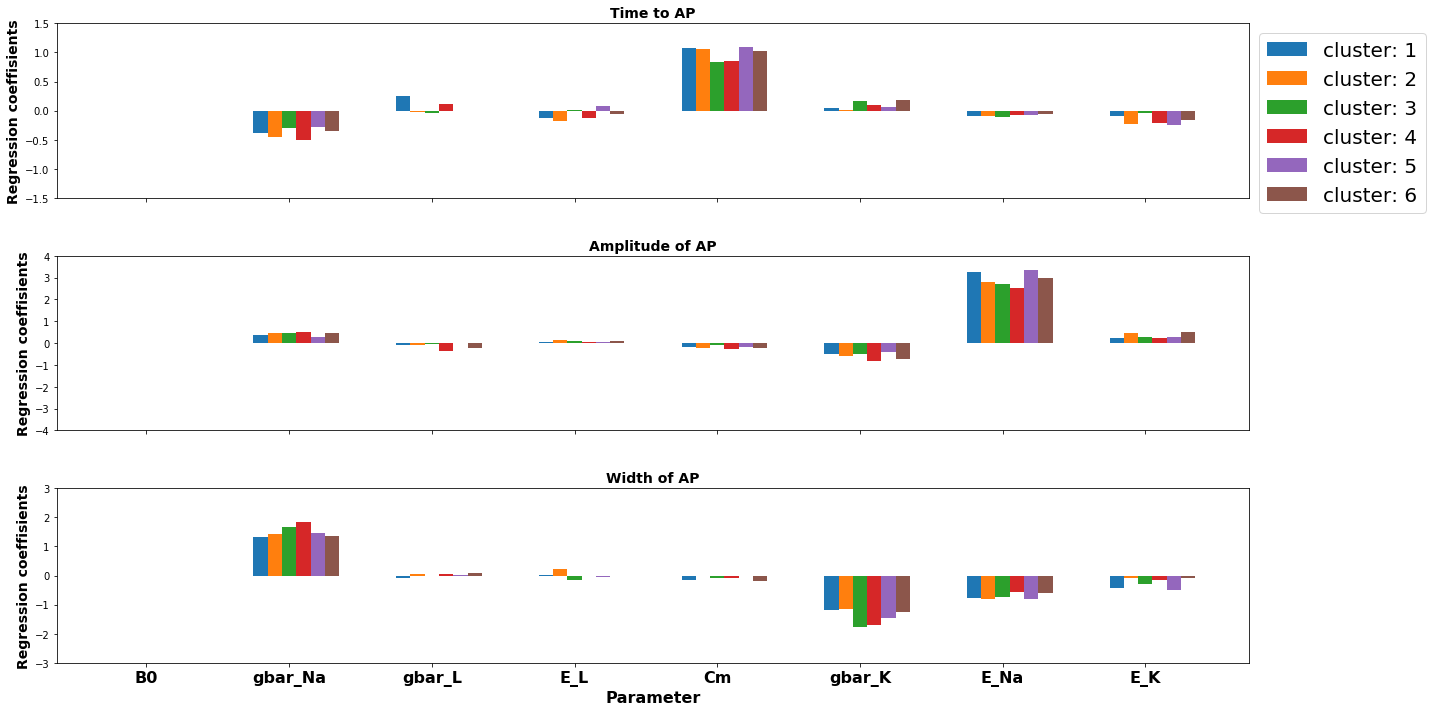

In [0]:

plt.figure(figsize=(20,10))
for n,agt in enumerate(ag_names):
  plt.subplot(3,1,n+1)
  plt.title(ag_names[n],fontweight='bold',fontsize=14)
  width=0.1


  x = np.array([i for i in range(1,9)])
  plt.bar(x-0.2,Bgr[0,:8,n].T,width=width,label='cluster: 1');
  plt.bar(x-0.1,Bgr[1,:8,n].T,width=width,label='cluster: 2');
  plt.bar(x    ,Bgr[2,:8,n].T,width=width,label='cluster: 3');
  plt.bar(x+0.1,Bgr[3,:8,n].T,width=width,label='cluster: 4');
  plt.bar(x+0.2,Bgr[4,:8,n].T,width=width,label='cluster: 5');
  plt.bar(x+0.3,Bgr[5,:8,n].T,width=width,label='cluster: 6');
  
  
  if n == 0:
    plt.ylim(-1.5,1.5)
    plt.ylabel('Regression coeffisients',fontweight='bold',fontsize=14)
    plt.tick_params(axis='x',labelbottom=False)
    plt.legend(bbox_to_anchor=(1, 1),prop={'size': 20})
    
  elif n == 1:
    plt.ylim(-4,4)
    plt.ylabel('Regression coeffisients',fontweight='bold',fontsize=14)
    plt.tick_params(axis='x',labelbottom=False)
    
    
  else:
    plt.ylim(-3,3)
    plt.ylabel('Regression coeffisients',fontweight='bold',fontsize=14)
    plt.xticks(x,headers[:8],fontweight='bold',fontsize=16);
    plt.xlabel('Parameter',fontweight='bold',fontsize=16)
    
    
    


plt.tight_layout()
plt.savefig("drive/My Drive/Figures/HCPLSR/HHag_orginal")


## Significant second order and interaction regression coefficients

In [0]:
sign_indexes = []
sign_headers = []
for agt in range(3):
  sign_ind = []
  sign_head = []
  for i in range(8,Bgr.shape[1]):

    if np.any(abs(np.squeeze(Bgr[:,i,agt])) > np.max(abs(Bgr[:,:8,agt]))*0.05):  # Significant if 5% of maximum value
      sign_ind.append(i)
      sign_head.append(headers[i])
  sign_indexes.append(sign_ind)
  sign_headers.append(sign_head)
  
sign_indexes = np.array(sign_indexes)

In [0]:
sign_indexes[2]

[8, 10, 13, 15, 21, 22, 27, 28, 29, 33, 35]

In [0]:
sign_headers

[['Cm*gbar_K', 'E_K*E_K'],
 [],
 ['gbar_Na*gbar_Na',
  'gbar_Na*E_L',
  'gbar_Na*E_Na',
  'gbar_L*gbar_L',
  'E_L*E_L',
  'Cm^2',
  'Cm*gbar_K',
  'Cm*E_Na',
  'Cm*E_K',
  'E_Na*E_Na',
  'E_K*E_K']]

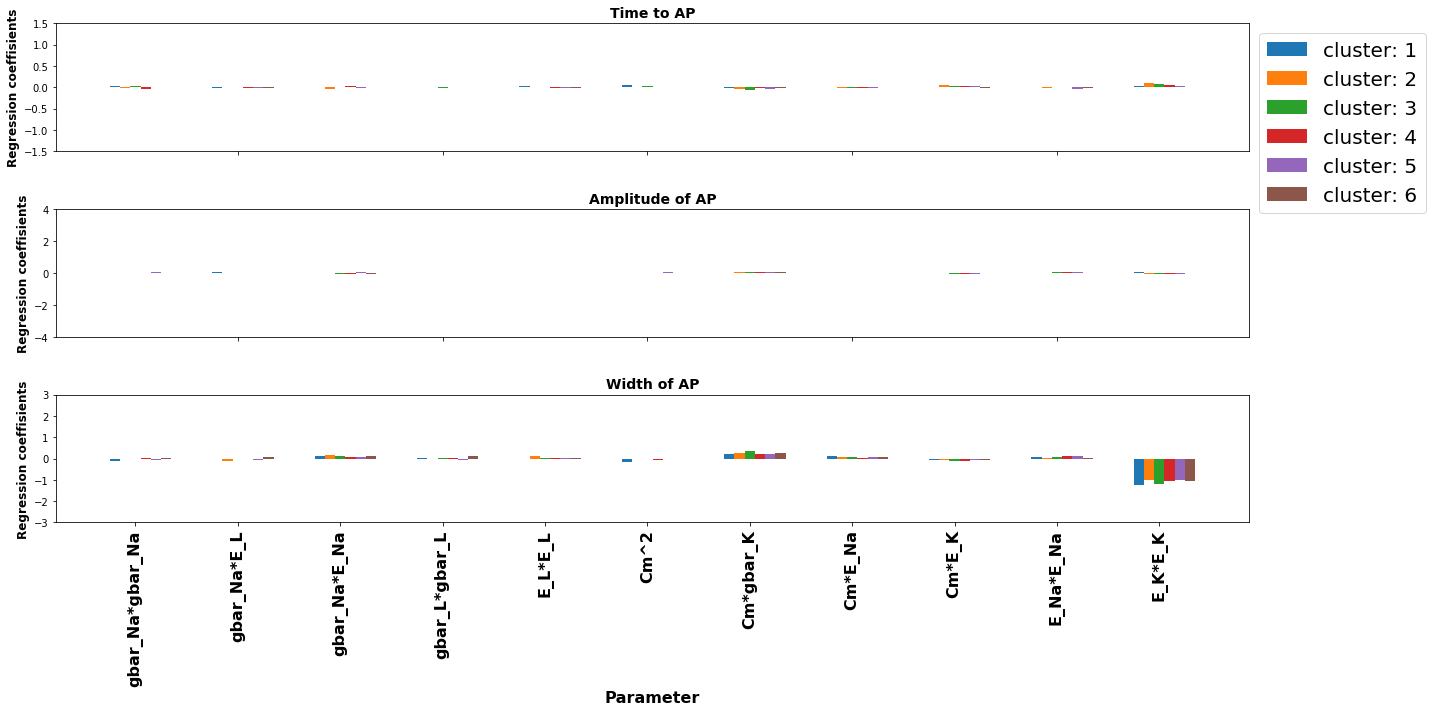

In [0]:
new_sign_indexes = np.array(sign_indexes[2])
new_sign_headers = np.array(sign_headers[2])
plt.figure(figsize=(20,10))
for n,agt in enumerate(ag_names):
  plt.subplot(3,1,n+1)
  plt.title(ag_names[n],fontweight='bold',fontsize=14)
  width=0.1


  x = np.array([i for i in range(1,12)])
  plt.bar(x-0.2,Bgr[0,new_sign_indexes,n].T,width=width,label='cluster: 1');
  plt.bar(x-0.1,Bgr[1,new_sign_indexes,n].T,width=width,label='cluster: 2');
  plt.bar(x    ,Bgr[2,new_sign_indexes,n].T,width=width,label='cluster: 3');
  plt.bar(x+0.1,Bgr[3,new_sign_indexes,n].T,width=width,label='cluster: 4');
  plt.bar(x+0.2,Bgr[4,new_sign_indexes,n].T,width=width,label='cluster: 5');
  plt.bar(x+0.3,Bgr[5,new_sign_indexes,n].T,width=width,label='cluster: 6');

  if n == 0:
    plt.ylim(-1.5,1.5)
    plt.ylabel('Regression coeffisients',fontweight='bold',fontsize=12)
    plt.tick_params(axis='x',labelbottom=False)
    plt.legend(bbox_to_anchor=(1, 1),prop={'size': 20})
    
  elif n == 1:
    plt.ylim(-4,4)
    plt.ylabel('Regression coeffisients',fontweight='bold',fontsize=12)
    plt.tick_params(axis='x',labelbottom=False)
    
    
  else:
    plt.ylim(-3,3)
    plt.ylabel('Regression coeffisients',fontweight='bold',fontsize=12)
    plt.xticks(x,new_sign_headers,fontweight='bold',fontsize=16,rotation=90);
    plt.xlabel('Parameter',fontweight='bold',fontsize=16)
    
    
    


plt.tight_layout()
plt.savefig("drive/My Drive/Figures/HCPLSR/HHag_interaction2")

